## 영화리뷰 텍스트 감성분석하기

#### 학습목표

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	
    - 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	
    - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

#### 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [14]:
train_data.shape

(146183, 3)

In [2]:
import numpy as np
import tensorflow as tf
import os

#### 2) 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [5]:
print('<PAD>' in word_to_index)  # True이면 정상, False이면 존재하지 않음
print(word_to_index.keys())

False
dict_keys(['', '.', '영화', '다', '고', '하', '을', '보', '..', '게', ',', '!', '지', '있', '없', '?', '좋', '나', '었', '만', '는데', '너무', '봤', '적', '안', '정말', '로', '음', '것', '아', '네요', '재밌', '어', '같', '점', '지만', '진짜', '했', '에서', '기', '네', '않', '거', '았', '수', '되', '면', 'ㅋㅋ', '말', '연기', '인', '주', '내', '최고', '~', '평점', '이런', '던', '어요', '할', '왜', '겠', '1', '스토리', '해', '습니다', 'ㅋㅋㅋ', '...', '드라마', '생각', '아니', '더', '그', '싶', '사람', '듯', '때', '감동', '함', '배우', '본', '까지', '뭐', '알', '만들', '내용', '볼', '감독', '보다', '라', '그냥', '재미', '시간', '지루', '중', '재미있', '년', '10', '였', '잼', '사랑', '못', '냐', '재미없', '쓰레기', '서', '2', '라고', '야', '니', '면서', '번', '다시', '나오', '작품', '이거', '하나', '줄', '해서', '개', '남', '정도', '마지막', '끝', '이건', '액션', '임', 'ㅋ', '3', '기대', '입니다', '건', '라는', '분', '완전', '다는', '참', '많', '처음', '장면', '대', '아깝', '다가', '으면', '지금', '모르', '이렇게', "'", '편', '일', '돈', '이게', '성', '느낌', '시', '이야기', '최악', '된', '봐도', '님', '어서', '애', '전', '넘', 'ㅠㅠ', '인데', '다고', '이해', '별로', '그리고', '명작', '여자', '^^', '역시', '난', '이상', '또', '걸',

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 3) 모델 구성을 위한 데이터 분석 및 가공 

In [8]:
## 데이터셋 문장 길이 분포 확인 및 최대 문장 길이 지정
## maxlen : 41

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
## keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
## pre, post 결정

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


#### 4) 모델 구성 및 validation set 구성

In [10]:
vocab_size = 10000    
word_vector_dim = 16

In [11]:
# simpleRNN 모델
model_simpleRNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.SimpleRNN(8),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_simpleRNN.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 16)          528       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,809
Trainable params: 160,809
Non-trainable params: 0
_________________________________________________________________


In [12]:
# GRU 모델
model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.GRU(16, return_sequences=True),  # return_sequences=True를 통해 스택 가능
    tf.keras.layers.GRU(8),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, None, 16)          1632      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 162,337
Trainable params: 162,337
Non-trainable params: 0
_________________________________________________________________


In [13]:
# BiLSTM 모델
model_BiLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_BiLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 32)          4224      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                2624      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 166,993
Trainable params: 166,993
Non-trainable params: 0
_________________________________________________________________


#### 5) 모델 훈련 개시

In [16]:
X_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [20]:
def fit_model(model, epochs=20):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)
    return history

#### 6) Loss, Accuracy 그래프 시각화

In [24]:
import matplotlib.pyplot as plt

def show_loss(history):
    history_dict = history.history
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def show_acc(history):
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [22]:
history_simpleRNN = fit_model(model_simpleRNN)

Epoch 1/20
208/208 [==============================] - 15s 68ms/step - loss: 0.1768 - accuracy: 0.9381 - val_loss: 0.5210 - val_accuracy: 0.8173
Epoch 2/20
208/208 [==============================] - 14s 67ms/step - loss: 0.1661 - accuracy: 0.9424 - val_loss: 0.5640 - val_accuracy: 0.8115
Epoch 3/20
208/208 [==============================] - 14s 67ms/step - loss: 0.1586 - accuracy: 0.9451 - val_loss: 0.5544 - val_accuracy: 0.8123
Epoch 4/20
208/208 [==============================] - 14s 67ms/step - loss: 0.1551 - accuracy: 0.9471 - val_loss: 0.5670 - val_accuracy: 0.8109
Epoch 5/20
208/208 [==============================] - 14s 67ms/step - loss: 0.1499 - accuracy: 0.9490 - val_loss: 0.5768 - val_accuracy: 0.8107
Epoch 6/20
208/208 [==============================] - 14s 67ms/step - loss: 0.1441 - accuracy: 0.9515 - val_loss: 0.5957 - val_accuracy: 0.8087
Epoch 7/20
208/208 [==============================] - 14s 67ms/step - loss: 0.1400 - accuracy: 0.9536 - val_loss: 0.5946 - val_accuracy:

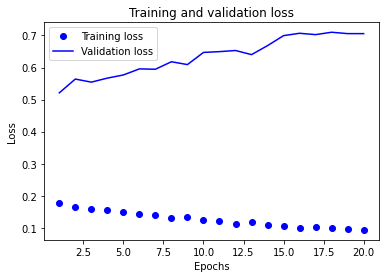

In [25]:
show_loss(history_simpleRNN)

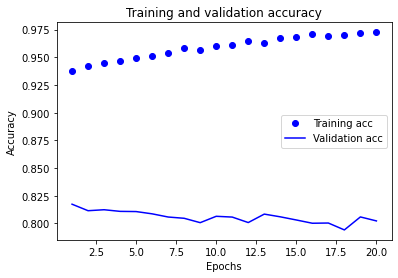

In [26]:
show_acc(history_simpleRNN)

In [27]:
history_GRU = fit_model(model_GRU)

Epoch 1/20
208/208 [==============================] - 26s 11ms/step - loss: 0.6870 - accuracy: 0.5180 - val_loss: 0.5333 - val_accuracy: 0.7712
Epoch 2/20
208/208 [==============================] - 1s 7ms/step - loss: 0.3963 - accuracy: 0.8270 - val_loss: 0.3547 - val_accuracy: 0.8463
Epoch 3/20
208/208 [==============================] - 1s 7ms/step - loss: 0.3296 - accuracy: 0.8619 - val_loss: 0.3486 - val_accuracy: 0.8498
Epoch 4/20
208/208 [==============================] - 2s 7ms/step - loss: 0.3131 - accuracy: 0.8708 - val_loss: 0.3527 - val_accuracy: 0.8476
Epoch 5/20
208/208 [==============================] - 2s 7ms/step - loss: 0.2982 - accuracy: 0.8771 - val_loss: 0.3442 - val_accuracy: 0.8521
Epoch 6/20
208/208 [==============================] - 2s 7ms/step - loss: 0.2860 - accuracy: 0.8837 - val_loss: 0.3483 - val_accuracy: 0.8517
Epoch 7/20
208/208 [==============================] - 1s 7ms/step - loss: 0.2734 - accuracy: 0.8895 - val_loss: 0.3451 - val_accuracy: 0.8526
Epoc

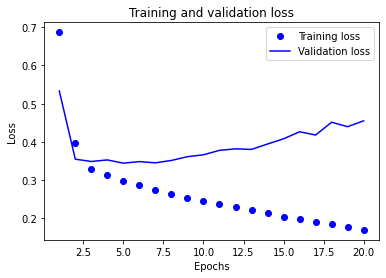

In [28]:
show_loss(history_GRU)

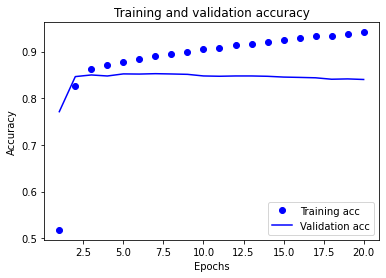

In [29]:
show_acc(history_GRU)

In [30]:
history_BiLSTM = fit_model(model_BiLSTM)

Epoch 1/20
208/208 [==============================] - 8s 17ms/step - loss: 0.4950 - accuracy: 0.7670 - val_loss: 0.3679 - val_accuracy: 0.8418
Epoch 2/20
208/208 [==============================] - 2s 12ms/step - loss: 0.3410 - accuracy: 0.8556 - val_loss: 0.3530 - val_accuracy: 0.8481
Epoch 3/20
208/208 [==============================] - 2s 12ms/step - loss: 0.3183 - accuracy: 0.8663 - val_loss: 0.3525 - val_accuracy: 0.8461
Epoch 4/20
208/208 [==============================] - 2s 12ms/step - loss: 0.3074 - accuracy: 0.8714 - val_loss: 0.3638 - val_accuracy: 0.8445
Epoch 5/20
208/208 [==============================] - 2s 12ms/step - loss: 0.2980 - accuracy: 0.8753 - val_loss: 0.3635 - val_accuracy: 0.8444
Epoch 6/20
208/208 [==============================] - 2s 12ms/step - loss: 0.2862 - accuracy: 0.8804 - val_loss: 0.3645 - val_accuracy: 0.8449
Epoch 7/20
208/208 [==============================] - 2s 12ms/step - loss: 0.2769 - accuracy: 0.8834 - val_loss: 0.3682 - val_accuracy: 0.8454

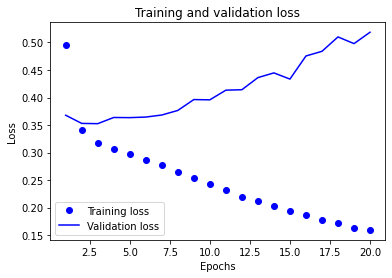

In [31]:
show_loss(history_BiLSTM)

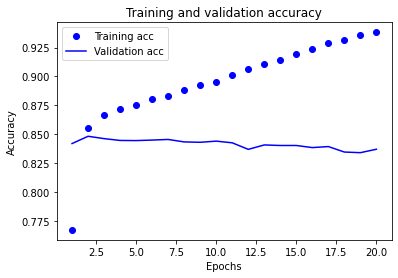

In [32]:
show_acc(history_BiLSTM)

In [33]:
results_simpleRNN = model_simpleRNN.evaluate(X_test,  y_test, verbose=2)
results_simpleRNN

1537/1537 - 11s - loss: 0.7148 - accuracy: 0.7993


[0.7147836685180664, 0.7993367910385132]

In [34]:
results_GRU = model_GRU.evaluate(X_test,  y_test, verbose=2)
results_GRU

1537/1537 - 4s - loss: 0.4643 - accuracy: 0.8340


[0.4643296003341675, 0.833980917930603]

In [35]:
results_BiLSTM = model_BiLSTM.evaluate(X_test,  y_test, verbose=2)
results_BiLSTM

1537/1537 - 6s - loss: 0.5257 - accuracy: 0.8331


[0.5257030129432678, 0.8331264853477478]

#### 7)학습된 Embedding 레이어 분석

#### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선